## <p style="text-align: center;"> <u>Testing Ziph's Word Frequency Law with Wikipedia Articles</u></p>
Ziph's law states that the frequency of words are inversely proportion to their frequency rank. The 2nd most frequent word is used 1/2 as often as the first, the 3rd is used 1/3 as often, the 4th: 1/4, the 5th: 1/5 and so on, following a power law.
https://en.wikipedia.org/wiki/Zipf%27s_law

<img src="https://scx2.b-cdn.net/gfx/news/2017/solutiontoac.png" width="707" height="415" />
<p style="text-align: center;">(source: https://phys.org/news/2017-08-unzipping-zipf-law-solution-century-old.html)
</p>

In this notebook I will attempt to find this relationship using a sample of Wikipedia articles.

For attaining a random sample of articles, I will start from a specified article, and have my code follow random links up to a specified number of articles, accumulating the raw text data on the way.

In [11]:
from bs4 import BeautifulSoup
import requests
import re
import random

def tokenize(string):
    return re.sub("[^\w\s]","", string).split()

def get_body(url):
    req = requests.get(url)
    soup = BeautifulSoup(req.text, 'lxml')
    return soup.find(id="bodyContent")

#find duplicate articles (for debugging), source:
#https://stackoverflow.com/questions/9835762/how-do-i-find-the-duplicates-in-a-list-and-create-another-list-with-them/9835819)
def list_duplicates(seq):
    seen = set()
    seen_add = seen.add
    seen_twice = set(x for x in seq if x in seen or seen_add(x))
    return list(seen_twice)

def scrapeWikipedia(url, n): #url = starting page, n = number of articles to scrape

    all_text = ""
    final_links = []
    temp_links = []
    exclude = ['https:',':','/ISO','Code_page']
    exclude2 = []
    skip_text = False
    
    for j in range(n):

        if skip_text == False:
        
            #grab raw text from webpage
            req = requests.get(url)
            soup = BeautifulSoup(req.text, 'lxml')
            raw_text = soup.findAll("p")

            for i in range(len(raw_text)):
                all_text += raw_text[i].text
            final_links.append(url) #every article that we've grabbed the text from
            temp_links.append(url) #for later use

        #choose next random link
        skip_text = False
        wikilinks = []
        links = get_body(url).findAll("a")
        for link in links:
            try:
                try:
                    if any(link['href'] == t[24:] for t in final_links) == False\
                    and '.' not in link['href'][-7:]\
                    and any(e in link['href'] for e in exclude) == False\
                    and any(link['href'] == s[24:] for s in exclude2) == False\
                    and '/wiki/' in link['href']:
                        wikilinks.append("https://en.wikipedia.org" + link['href'])
                except IndexError:
                    continue
            except KeyError:
                continue
        
        #make sure current article has at least 100 links to increase chances of branching into different domains
        #plus error handling for cases where get_body() returned a NoneType
        CarryOn = True
        if len(wikilinks) > 100: 
            random.shuffle(wikilinks)
            while CarryOn == True:
                for w in range(len(wikilinks)):
                    url = wikilinks[w]
                    if type(get_body(url) != type(None)):
                        CarryOn = False
                        break
                    else:
                        print(f"Currently searching for a suitable link")
                        del wikilinks[w]
                        if len(wikilinks) == 0:
                            del temp_links[-1]
                            url = temp_links[-1]
                            skip_text = True
                            CarryOn = False
                            break
        else:
            exclude2.append(url)
            del temp_links[-1]
            url = temp_links[-1]
            skip_text = True
        print(f"finished {j+1} loops",end='\r')
        
    print(f"Out of {n} loops we ended up with {len(final_links)} articles")
    print(f"Started on: {final_links[0]}")
    print(f"and ended up on: {final_links[-1]}")
    if len(final_links) == len(set(final_links)):
        print("Repeated articles: 0 (as expected)")
    else: 
        print(f"Repeated articles: {len(final_links) - len(set(final_links))} (check!)")
        print(list_duplicates(final_links))
        
    final_text = tokenize(all_text)
    return final_text

In [12]:
import time
start_time = time.perf_counter()

url = 'https://en.wikipedia.org/wiki/Wikipedia'
text_10000 = scrapeWikipedia(url, 10000)

print((time.perf_counter() - start_time)/60, " minutes")
print("total number of words: ",len(text_10000))
print("number of distinct words: ",len(set(text_10000)))

Out of 10000 loops we ended up with 8824 articles
Started on: https://en.wikipedia.org/wiki/Wikipedia
and ended up on: https://en.wikipedia.org/wiki/Laban_(Bible)
Repeated articles: 0 (as expected)
566.921094015  minutes
total number of words:  16824984
number of distinct words:  662006


In [153]:
import pandas as pd
data = [a.lower() for a in text_10000]
df = pd.DataFrame(data,columns=['word'])
df = df.groupby(['word']).word.size().to_frame('frequency').sort_values('frequency',ascending=False)

In [154]:
#after lower-casing
print("number of distinct words: ",len(set(data)))

number of distinct words:  614116


In [155]:
print(df[:100].index.values)

['the' 'of' 'and' 'in' 'to' 'a' 'is' 'as' 'was' 'for' 'by' 'that' 'with'
 'on' 'from' 'are' 'it' 'or' 'at' 'which' 'an' 'were' 'be' 'this' 'his'
 'he' 'also' 'not' 'has' 'have' 'its' 'their' 'had' 'but' 'other' 'one'
 'first' 'they' 'been' 'such' 'new' 'after' 'who' 'more' 'can' 'most'
 'all' 'some' 'into' 'two' 'there' 'during' 'used' 'may' 'when' 'these'
 'between' 'many' 'than' 'only' 'would' 'over' 'states' 'time' 'while'
 'state' 'united' 'world' 'about' 'city' 'war' 'under' 'however'
 'government' 'known' 'including' 'national' 'both' 'years' 'no' 'people'
 'where' 'through' 'number' 'since' 'part' 'being' 'use' 'three' 'became'
 'century' 'later' 'then' 'made' 'called' 'system' 'well' 'up' 'if' 'us']


**Expected value = Most Frequent Word * (1 / Frequency Rank)**

In [207]:
import numpy as np
df1 = df.copy()
df1 = df1.reset_index()
top25 = df1[:25]
base = top25.iloc[0][1]
expected = lambda x : np.round_(base * (1/(x.index.values + 1)),0)
top25['expected'] = top25[['frequency']].apply(expected)
top25 = top25.set_index('word')
top25

<ipython-input-207-b0def689dd84>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top25['expected'] = top25[['frequency']].apply(expected)


,frequency,expected
word,,
the,1302252,1302252.0
of,654609,651126.0
and,511436,434084.0
in,468706,325563.0
to,370975,260450.0
a,330520,217042.0
is,175131,186036.0
as,162643,162782.0
was,146618,144695.0


As we can see in the graph below, for many of the points they are almost spot on for what would be expected if Ziph's Law holds true.

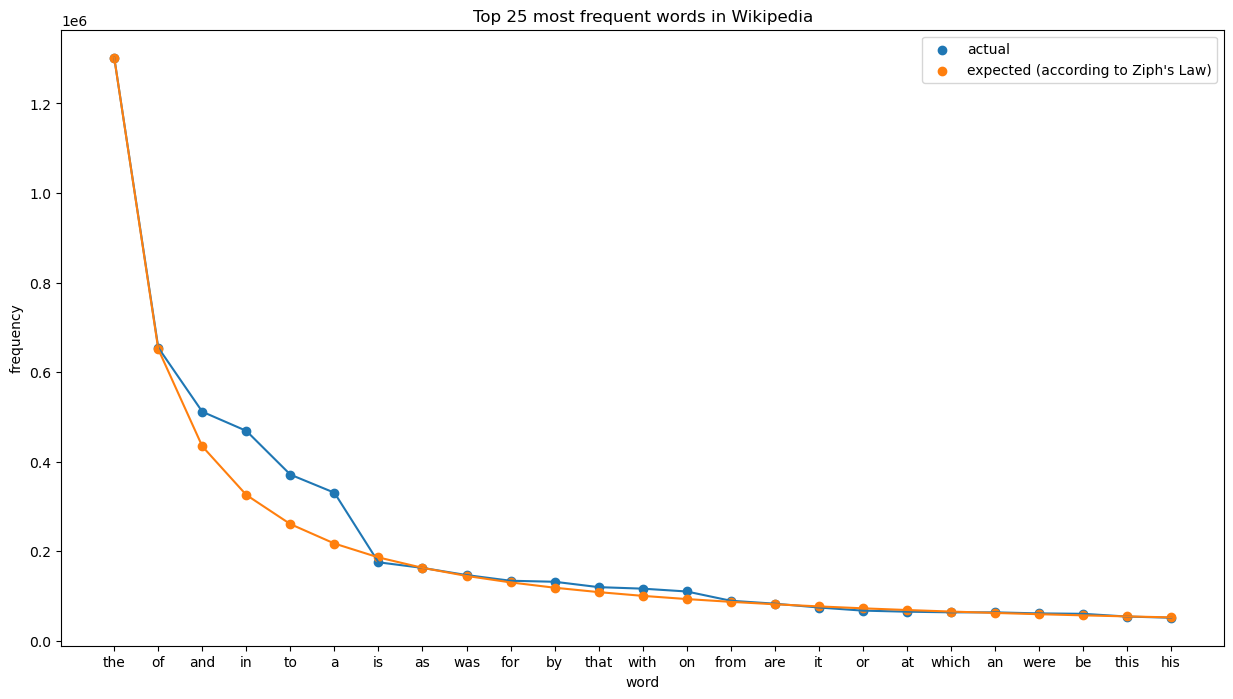

In [208]:
#plot
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

figure(figsize=(15,8))

x = top25.index.values
y1 = top25.frequency.values
y2 = top25.expected.values

plt.scatter(x,y1,label="actual")
plt.plot(x,y1)

plt.scatter(x,y2,label="expected (according to Ziph's Law)")
plt.plot(x,y2)

plt.xlabel('word')
plt.ylabel('frequency')

plt.title("Top 25 most frequent words in Wikipedia")

plt.legend()
plt.show()

Word Frequency Lookup

In [209]:
def FreqLookup(word):
    return (f"{[word]} makes up {round(100 * (df.loc[word].values[0] / np.sum(df['frequency'])),5)}% of the words in \
Wikipedia, at rank #{1 + df1[df1['word']==word].index[0]}")

In [210]:
word = 'data'
print(FreqLookup(word))

['data'] makes up 0.02272% of the words in Wikipedia, at rank #412
